# Caudales Albujón

In [110]:
from datetime import date
import getpass
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
import pandas as pd
import pandas.io.sql as psql
import scipy as sp
from scipy.optimize import curve_fit

%matplotlib widget

## Figure parameters

In [111]:
# graphs size
# default size 6.4 * 4.8
default_ratio = 6.4/4.8
print('defult ratio', 6.4/default_ratio)
x_cm = 11
x_in = x_cm / 2.54
y_in = x_in / default_ratio
print('x in', x_in)

defult ratio 4.8
x in 4.330708661417323


In [112]:
mpl.rcdefaults()

plt.rc('figure', figsize=(x_in, y_in), dpi=80)
plt.rc('font', size=8)
plt.rc('axes', labelsize=8, titlesize= 9, grid=True)
plt.rc('axes.spines', right=False, top=False)
plt.rc('xtick', direction='out', top=False)
plt.rc('ytick', direction='out', right=False)
plt.rc('lines', linewidth=0.8, linestyle='-', marker='.', markersize=4)
plt.rc('legend', fontsize=8, framealpha=0.5, loc='best')

plt.subplots_adjust(hspace=0.1, bottom=0.16, top=0.87)
plt.close()


## Database

In [113]:
db = getpass.getpass('DB: ')
user = getpass.getpass('User: ')
passw = getpass.getpass('Password: ')
con = psycopg2.connect(database=db, user=user, password=passw)

DB:  ···
User:  ········
Password:  ··


## Functions

In [114]:
def subplot_1(x, y, str_title, str_ylabel, close_plt=True ):
    if close_plt:
        plt.close()
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    ax.stem(x, y, markerfmt=' ', basefmt=' ')
    ax.set_title(str_title)
    plt.ylabel(str_ylabel)
    plt.tight_layout()
    plt.show()

def subplot_n(x, y, legends, str_title, str_ylabel, close_plt=True ):
    """
    x[[]], y[[]], str_ylabel[]: sequences same number of elements
    x[i], y[i]: sequences same number of element; x[i] date type
    """
    if close_plt:
        plt.close()
    n = len(x)
    fig, ax = plt.subplots(n, 1, sharex=True)
    fig.autofmt_xdate()
    fig.suptitle(str_title, fontsize=9)

    for i in range(n):
        if i==0:
            ax[i].stem(x[i], y[i], markerfmt=' ', basefmt=' ', label=legends[i])
        else:
            color = f'C{i:d}'
            ax[i].stem(x[i], y[i], color, markerfmt=' ', basefmt=' ', label=legends[i])
        ax[i].legend()
        ax[i].set(ylabel=str_ylabel[i])
    plt.tight_layout()
    plt.show()

In [115]:
# exponential functions
def fexp2p(x, a, b):
    return a * np.exp(b * x)

def fexp3p(x, a, b, c):
    return a * np.exp(b * x) + c

def fexp4p(x, a, b, c, d):
    return a * np.exp(b * (x - c)) + d

def goodness_of_fit(f, x, y, popt, pcov=None):
    print('parameters: ', popt)
    if pcov is not None:
        print('covariance: ', pcov)
        perr = np.sqrt(np.diag(pcov))
        print(perr, '\n')

    # residual sum of squares (ss_res)
    residuals = y - f(x, *popt)
    ss_res = np.sum(residuals**2)
    # total sum of squares (ss_tot)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print('R**2 = ', r_squared) 
    return r_squared

## Albujón en desembocadura con pluviómetro

### Data plot

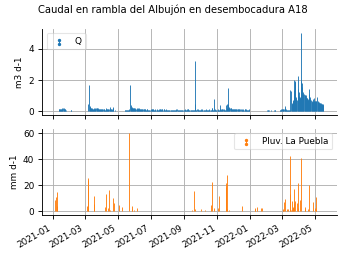

In [116]:
select = \
"""
select t.fecha::date fecha, (avg(t.v)) q from saih.tsh t  where id = '06a18' and t.var='q01'
group by t.fecha::date order by t.fecha::date
"""
df_alb18 = psql.read_sql(select, con)

select = \
"""
select t.fecha , round(t.v::numeric, 1) p from saih.tsd t 
where t.id = '06a01' and t.var = 'p01' and t.v>0 and t.fecha>= '2021-01-01' order by fecha
"""
df_a01_p = psql.read_sql(select, con)

subplot_n([df_alb18['fecha'], df_a01_p['fecha']],
          [df_alb18['q'], df_a01_p['p']],
          ['Q', 'Pluv. La Puebla'],
          'Caudal en rambla del Albujón en desembocadura A18',
          ['m3 d-1', 'mm d-1'])

In [117]:
df1 = df_alb18[(df_alb18['fecha'] > date(2022,3,15)) & (df_alb18['fecha'] <= date(2022,5,15))]

In [118]:
df1[0:10]

,fecha,q
395,2022-03-16,0.109521
396,2022-03-17,1.363487
397,2022-03-18,1.280646
398,2022-03-19,0.513125
399,2022-03-20,0.455321
400,2022-03-21,0.672475
401,2022-03-22,0.707854
402,2022-03-23,1.359879
403,2022-03-24,2.021479
404,2022-03-25,1.884067


### Recession modeling

2022-04-28 23:00:00-2022-05-04 median 655.6999999999999
                fecha       q
0 2022-04-28 23:00:00  1.4719
1 2022-04-29 00:00:00  1.3332
2 2022-04-29 01:00:00  1.1730
3 2022-04-29 02:00:00  1.0948
4 2022-04-29 03:00:00  1.0248
5 2022-04-29 04:00:00  0.9510
6 2022-04-29 05:00:00  0.8987
7 2022-04-29 06:00:00  0.8611
8 2022-04-29 07:00:00  0.8356
9 2022-04-29 08:00:00  0.8120


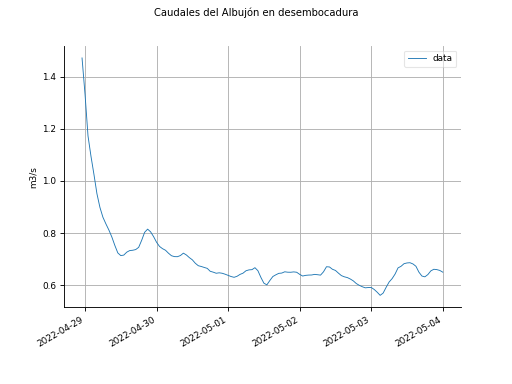

In [137]:
estacion_id = '06a18'
fecha1 = '2022-04-28 23:00:00' #'2022-05-08 00:00:00' # '2022-04-04 00:00:00'
fecha2 = '2022-05-04' #fecha2 = '2022-05-31'
select1 = \
"""
select t.fecha::date fecha, avg(t.v) q from saih.tsh t 
where id = %s and t.var='q01' and t.fecha>= %s and t.fecha<= %s 
group by t.fecha::date
order by t.fecha::date
"""
select2 = \
"""
select t.fecha fecha, t.v q from saih.tsh t 
where id = %s and t.var='q01' and t.fecha>= %s and t.fecha<= %s 
order by t.fecha
"""
select = select2
df = psql.read_sql(select, con, params=(estacion_id, fecha1, fecha2))
print(f'{fecha1}-{fecha2} median', np.median(df['q'])*1000)
print(df[0:10])

fig, ax = plt.subplots(figsize=(6.4, 4.8))
fig.autofmt_xdate()
fig.suptitle('Caudales del Albujón en desembocadura', fontsize=9)
ax.set(ylabel='m3/s')
ax.plot(df['fecha'], df['q'], '-', label='data')
ax.legend()
ax.grid(True)

In [120]:
pd.set_option('display.max_rows', None)

In [121]:
df[0:15]

,fecha,q
0,2022-04-28 23:00:00,1.4719
1,2022-04-29 00:00:00,1.3332
2,2022-04-29 01:00:00,1.1730
3,2022-04-29 02:00:00,1.0948
4,2022-04-29 03:00:00,1.0248
5,2022-04-29 04:00:00,0.9510
6,2022-04-29 05:00:00,0.8987
7,2022-04-29 06:00:00,0.8611
8,2022-04-29 07:00:00,0.8356
9,2022-04-29 08:00:00,0.8120


In [72]:
# xi = df.index.values.astype(np.double)


In [73]:
x = df['fecha'].to_numpy().astype(np.datetime64).astype(np.float64)
x = x - x[0]
y = df['q'].to_numpy().astype(np.float64)

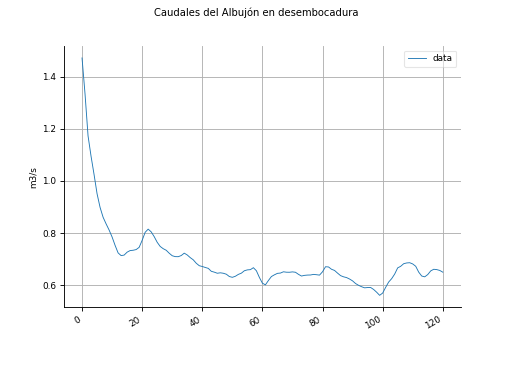

In [138]:
plt.close()
fig, ax = plt.subplots(figsize=(6.4, 4.8))
fig.autofmt_xdate()
fig.suptitle('Caudales del Albujón en desembocadura', fontsize=9)
ax.set(ylabel='m3/s')
ax.plot(xi, y, '-', label='data')
ax.legend()
ax.grid(True)

In [122]:
fecha1 = '2022-04-28 23:00:00'
fecha2 = '2022-04-29 24:00:00'

select3 = \
"""
select t.fecha fecha, t.v q from saih.tsh t 
where id = %s and t.var='q01' and t.fecha>= %s and t.fecha<= %s 
order by t.fecha
"""
select = select2
df = psql.read_sql(select, con, params=(estacion_id, fecha1, fecha2))
print(f'{fecha1}-{fecha2} median', np.median(df['q'])*1000)
print(df[0:10])


2022-04-28 23:00:00-2022-04-29 24:00:00 median 794.9
                fecha       q
0 2022-04-28 23:00:00  1.4719
1 2022-04-29 00:00:00  1.3332
2 2022-04-29 01:00:00  1.1730
3 2022-04-29 02:00:00  1.0948
4 2022-04-29 03:00:00  1.0248
5 2022-04-29 04:00:00  0.9510
6 2022-04-29 05:00:00  0.8987
7 2022-04-29 06:00:00  0.8611
8 2022-04-29 07:00:00  0.8356
9 2022-04-29 08:00:00  0.8120


In [139]:
xs = np.array([0, 3.5, 11.9])
ys = np.array([1.5, 1, 0.7])
f = fexp2p
pguess = (1.5, 0.6)
popt, pcov = curve_fit(f, xs, ys)
rsq = goodness_of_fit(f, xs, ys, popt, pcov)

parameters:  [ 1.43002883 -0.06831742]
covariance:  [[ 0.02017168 -0.00179471]
 [-0.00179471  0.00050544]]
[0.14202705 0.02248204] 

R**2 =  0.9232623051609055


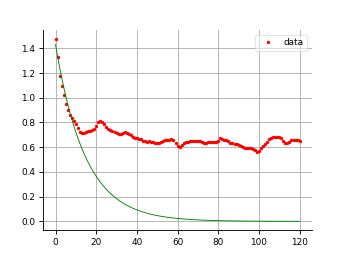

In [140]:
plt.close()
fig, ax = plt.subplots()
ax.plot(xi, y, 'r.', label='data')
ax.plot(xi, f(xi, *popt), 'g-') #, label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
ax.legend()
ax.grid(True)